In [207]:
#to handle datasets
import pandas as pd
import numpy as np

# for plotting
import matplotlib.pyplot as plt
import pylab as pl
import seaborn as sns
import xgboost as xgb

#for the yeo-johnson transform
import scipy.stats as stats
#to display all the columns
pd.pandas.set_option('display.max_columns', None)

In [208]:
#hyperparameters
DATASET='test'
# DATASET='train'
# HEATER = 'H160'
# HEATER = 'H161'
HEATER = 'H103'
MAX_HEAD_PRESSURE = 400
MIN_HEAD_TEMPERATURE = 50
MIN_WEIGHT = 1400

In [209]:
# load the data
df = pd.read_csv('./data/' + DATASET + '/' +HEATER + '.csv', parse_dates=['utc_time'])
df.columns = ['time','batch','phase', 'heat_time', 'weight', 'head_temp', 'head_pressure', 'vac_temp']
# df = df[df['phase'].str.contains('DRYING|HEATING|FEED|FEEDING') == True]
df.replace({'??????': 0,'????????': 0, '???????': 0}, inplace=True)
df = df[df['phase'].str.contains('DRYING|HEATING') == True]
df.dropna(inplace=True)

In [210]:
df.batch = df.batch.astype(float)
df.batch = df.batch.astype(int)
df['heat_time'] = df.heat_time.astype(float)
df['weight'] = df.weight.astype(float)
df['head_temp'] = df.head_temp.astype(float)
df['head_pressure'] = df.head_pressure.astype(float)
df['vac_temp'] = df.vac_temp.astype(float)

In [211]:
from scipy.signal import argrelextrema
# find local maximums
n = 30 # number of points to be checked before and after

df['max_temp'] = df.iloc[argrelextrema(df.head_temp.values, np.greater_equal, order=n)]['head_temp']
df['max_temp'] = df['max_temp'].fillna(0)

In [212]:
df['ready'] = 0
DELTA_TIME = 2  # time after max to be considered ready
DELTA_TEMP = 1 # temp delta to consider ready
df['ready'] = df.ready.astype(int)

for i in range(1, len(df)-1):
    if df.max_temp.values[i] > 0 and df.head_temp.values[i] > MIN_HEAD_TEMPERATURE:
        local_max = df.max_temp.values[i]
        current = df.batch.values[i]
        local_max_index = i
        while df['batch'].values[i] == current and i < len(df)-1:
            if local_max - df.head_temp.values[i] > DELTA_TEMP  and i > local_max_index + DELTA_TIME:
                df.ready.values[i] = 1
            i += 1

In [213]:
#create lag features
df['lag_heat_time_20'] = df.heat_time.shift(20)
df['lag_weight_20'] = df.weight.shift(20)
df['lag_head_temp_20'] = df.head_temp.shift(20)
df['lag_head_pressure_20'] = df.head_pressure.shift(20)
df['lag_vac_temp_20'] = df.vac_temp.shift(20)

df['lag_heat_time_30'] = df.heat_time.shift(30)
df['lag_weight_30'] = df.weight.shift(30)
df['lag_head_temp_30'] = df.head_temp.shift(30)
df['lag_head_pressure_30'] = df.head_pressure.shift(30)
df['lag_vac_temp_30'] = df.vac_temp.shift(30)

df['lag_heat_time_40'] = df.heat_time.shift(40)
df['lag_weight_40'] = df.weight.shift(40)
df['lag_head_temp_40'] = df.head_temp.shift(40)
df['lag_head_pressure_40'] = df.head_pressure.shift(40)
df['lag_vac_temp_40'] = df.vac_temp.shift(40)

In [214]:
#choose the features
features = [
            'heat_time','weight', 'head_temp', 'head_pressure', 'vac_temp',
            'lag_heat_time_20', 'lag_weight_20', 'lag_head_temp_20', 'lag_head_pressure_20', 'lag_vac_temp_20',
            'lag_heat_time_30', 'lag_weight_30', 'lag_head_temp_30', 'lag_head_pressure_30', 'lag_vac_temp_30',
            'lag_heat_time_40', 'lag_weight_40', 'lag_head_temp_40', 'lag_head_pressure_40', 'lag_vac_temp_40',

            ]
label = ['ready']

In [215]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df[features], df[label], shuffle = False)

In [216]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
                            n_estimators=1000,
                            max_depth=5,
                            learning_rate=0.1,
                            seed=42)

In [217]:
clf_xgb.fit(X_train,
            y_train,
            verbose=True,
            early_stopping_rounds=20,
            eval_metric='auc',
            eval_set=[(X_train, y_train),(X_test, y_test)])

[0]	validation_0-auc:0.93298	validation_1-auc:0.85602
[1]	validation_0-auc:0.94774	validation_1-auc:0.84897
[2]	validation_0-auc:0.95291	validation_1-auc:0.84393
[3]	validation_0-auc:0.97152	validation_1-auc:0.86300


/home/bazdalaz/.cache/pypoetry/virtualenvs/dryers-730-aZtdCMLp-py3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/bazdalaz/.cache/pypoetry/virtualenvs/dryers-730-aZtdCMLp-py3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[4]	validation_0-auc:0.97530	validation_1-auc:0.86750
[5]	validation_0-auc:0.97615	validation_1-auc:0.86754
[6]	validation_0-auc:0.97862	validation_1-auc:0.86929
[7]	validation_0-auc:0.98067	validation_1-auc:0.87486
[8]	validation_0-auc:0.98335	validation_1-auc:0.88361
[9]	validation_0-auc:0.98705	validation_1-auc:0.88935
[10]	validation_0-auc:0.98785	validation_1-auc:0.89060
[11]	validation_0-auc:0.98884	validation_1-auc:0.89477
[12]	validation_0-auc:0.98922	validation_1-auc:0.89920
[13]	validation_0-auc:0.98953	validation_1-auc:0.90192
[14]	validation_0-auc:0.99028	validation_1-auc:0.90566
[15]	validation_0-auc:0.99034	validation_1-auc:0.90961
[16]	validation_0-auc:0.99080	validation_1-auc:0.91135
[17]	validation_0-auc:0.99114	validation_1-auc:0.91394
[18]	validation_0-auc:0.99146	validation_1-auc:0.91462
[19]	validation_0-auc:0.99204	validation_1-auc:0.91818
[20]	validation_0-auc:0.99275	validation_1-auc:0.92227
[21]	validation_0-auc:0.99333	validation_1-auc:0.92493
[22]	validation_

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=1000,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, ...)

<AxesSubplot:>

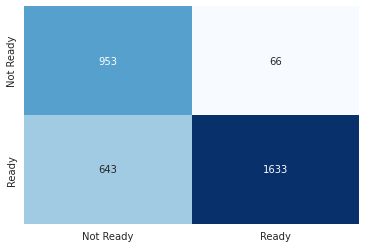

In [218]:

from sklearn.metrics import confusion_matrix
import seaborn as sns

pred = clf_xgb.predict_proba(X_test)[:,1]
thr = 0.7


sns.heatmap(confusion_matrix(y_test, pred > thr), annot=True, fmt='', cmap='Blues', cbar=False,
            xticklabels=['Not Ready', 'Ready'], yticklabels=['Not Ready', 'Ready'])

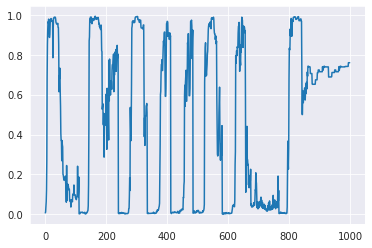

In [219]:
plt.plot(pd.Series(pred[-1000:]))

In [220]:
from sklearn.metrics import classification_report
print(HEATER + ', ' + DATASET + ', accuracy: ' + str(clf_xgb.score(X_test, y_test)))
print(classification_report(y_test, clf_xgb.predict_proba(X_test)[:,1]>thr, target_names=['Not Ready','Ready']), sep='\n')
print(confusion_matrix(y_test, clf_xgb.predict_proba(X_test)[:,1]>thr))

H103, test, accuracy: 0.8306525037936268
              precision    recall  f1-score   support

   Not Ready       0.60      0.94      0.73      1019
       Ready       0.96      0.72      0.82      2276

    accuracy                           0.78      3295
   macro avg       0.78      0.83      0.78      3295
weighted avg       0.85      0.78      0.79      3295

[[ 953   66]
 [ 643 1633]]
